# Lab 8

**Lecture**: Deep Learning (Prof. Dr. David Rügamer, Emanuel Sommer)

## Imports

In [1]:
import random
import shutil
import urllib.request
from functools import reduce, partial
from math import ceil
from pathlib import Path
from typing import Optional, Callable

import matplotlib.pyplot as plt
import torch
from PIL import Image
from matplotlib_inline.backend_inline import set_matplotlib_formats
from torch import nn, Tensor
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import transforms
from torchvision.models import vgg16

set_matplotlib_formats('png', 'pdf')

## Exercise 1
NB: it is impractical to do this exercise on your laptop, even if you have a GPU.
You are advised to work on
[Google Colab](https://colab.research.google.com).

In this exercise we would like to build a classification system for 120 different breeds
of dogs, based on commonplace pictures. The data is available on
[Kaggle](https://www.kaggle.com/c/dog-breed-identification/data) (permanent, requires an
account) or [Dropbox](https://www.dropbox.com/s/l7b7l5fjwwj6ad2/dog-breed-identification.zip?dl=0)
(temporary, no login needed).
Download it and unzip it, then put the contents in a folder named `.data/DOGBREED`.
Otherwise, execute the code below.

In [2]:
# If you have problems downloading from python, try from a browser.
url = 'https://www.dropbox.com/s/l7b7l5fjwwj6ad2/dog-breed-identification.zip?dl=1'
data_root = '.data'
dataset_dir = Path(data_root, 'DOGBREED')
file_name = 'dog-breed-identification.zip'
file_path = Path(data_root, file_name)

if not dataset_dir.exists():
    Path(data_root).mkdir(exist_ok=True)
    urllib.request.urlretrieve(url, file_path)
    shutil.unpack_archive(file_path, dataset_dir)
    file_path.unlink()

KeyboardInterrupt: 

This dataset is composed of 10222 pictures in different resolutions and aspect rations.
The smallest classes are Briad and Eskimo dog with only 66 images each, whereas the
biggest class is the Scottish deerhound with 126 images.

Here are some sample images along with the relative label:

In [ ]:
with open(Path(dataset_dir, 'labels.csv')) as file:
    label_list = file.readlines()

label_list = [label_entry.strip().split(sep=',') for label_entry in label_list][1:]
print(label_list[:3])

[['000bec180eb18c7604dcecc8fe0dba07', 'boston_bull'], ['001513dfcb2ffafc82cccf4d8bbaba97', 'dingo'], ['001cdf01b096e06d78e9e5112d419397', 'pekinese']]


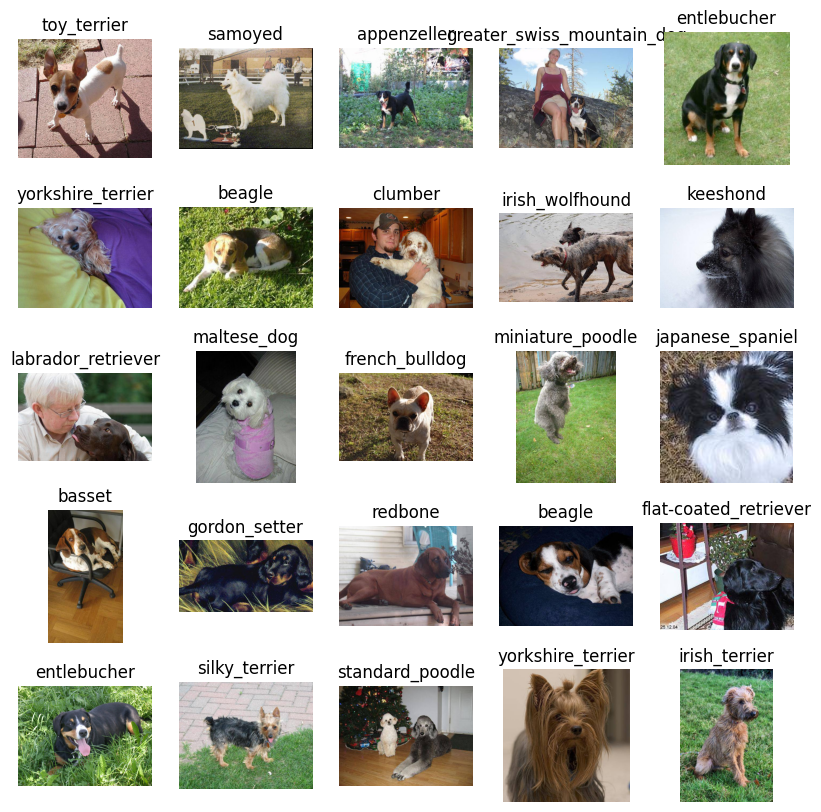

In [ ]:
_, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()
for ax in axs:
    rand_file, rand_label = tuple(label_list[random.randint(0, len(label_list))])
    img = Image.open(Path(dataset_dir, 'train', rand_file + '.jpg'))
    ax.imshow(img)
    ax.set_title(rand_label)
    ax.axis('off')
plt.show()


This is a challenging problem since there are many classes and only few instances per
class. Moreover, the images contain a lot of details that do not help to identify the
dogs, but allow a network to easily memorize the data. We will first try to naively
approach the problem and directly train a CNN on this dataset.
After convincing ourselves that this is not going to work, we will use a pre-trained
VGG16 (i.e., trained successfully on some other dataset) and fine-tune it to our data.

But first, we do a bit of data organizing to reserve some images for a validation subset.
Afterwards, we will create a custom `Dataset` that conveniently loads images on the fly
during our training procedure.

We will also convert our labels to integers and create a dict with the reverse mapping.

In [ ]:
# Shuffle list of all keys and labels
random.shuffle(label_list)
val_size = len(label_list) // 5

# Split in training and validation sets
train_label_list = label_list[val_size:]
val_label_list = label_list[:val_size]

# Extract keys and labels
train_keys, train_labels = zip(*train_label_list)
val_keys, val_labels = zip(*val_label_list)

# Get all unique classes
unique_classes = set([label_entry[1] for label_entry in label_list])
print('Number of classes: {}'.format(len(unique_classes)))

# Create class mappings
num_to_class_mapping = {i: class_label for i, class_label in enumerate(unique_classes)}
class_to_num_mapping = {class_label: i for i, class_label in enumerate(unique_classes)}

# Convert string labels to integers
train_labels = [class_to_num_mapping[label] for label in train_labels]
val_labels = [class_to_num_mapping[label] for label in val_labels]

Number of classes: 120


In [ ]:

class DogBreedDataset(Dataset):
    def __init__(self,
                 keys: list[str],
                 labels: [int],
                 img_root: Optional[Path] = None,
                 transform: Optional[Callable] = None
                 ):
        """
        Initialize a dog breed dataset.

        :param keys: list of identifiers for the images.
        :param labels: list of labels for the identifiers.
        :param img_root: Path pointing to the image directory.
        :param transform: Transformation to apply on loaded image.
        """

        self.keys = keys
        self.labels = labels
        self.transform = transform

        if img_root is None:
            self.img_root = Path('.data', 'DOGBREED', 'train')
        else:
            self.img_root = img_root


    def __len__(self) -> int:
        return len(self.keys)

    @property
    def shape(self) -> tuple:
        return self[0][0].shape

    def __getitem__(self, idx: int) -> tuple[Tensor, Tensor]:
        key = self.keys[idx]
        img = (
# TODO: Load the image corresponding to the key to memory as a PIL image.
                Image.open(Path(self.img_root, key + ".jpg"))        
                )

        if self.transform is not None:
            img = self.transform(img)

        y = (
# TODO: Get the right label and convert it to a tensor.
            torch.tensor(self.labels[idx], dtype = torch.long)
        )


        return img, y

### Data preparation
As this dataset is fairly small, we can generate more synthetic images by applying random
transformations to the images we have.
You might have noticed that our `DogBreedDataset` already takes `transform` as an argument,
where we will pass some functions, that transform our images during training.
Everytime a new batch of data is requested, the augmentations are randomly applied on-the-fly.
This saves a lot of memory, at the price of larger computational resources needed.

This technique is called _data augmentation_,
and it can greatly help in reducing overfitting on small datasets.

For this task we can use the `transforms` module of `torchvision` (check the docs
[here](https://pytorch.org/vision/stable/transforms.html)). To chain multiple transformations,
we use `Compose`.

We now want to randomly perform the following transformations to each image:

 - Flip horizontally
 - Rotation of at most 30 degrees
 - Change brightness, contrast and saturation (`ColorJitter`)
 - Change perspective (`RandomPerspective`)
 - Resize to $224 \times 224$
 - Convert from PIL image to a tensor with a range 0 to 1 (now 0 to 255).

We do not use random augmentation for the validation images except for centering and
scaling. Why?

In [ ]:

# Resizing to a square with varying aspect ratios per image can be a bit tricky.
# We define a small custom transformation, where we will pad the input to a square shape
# and then do the resizing.
# More info: https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850
class ResizeToSquare:
    def __init__(self, size: int):
        self.resize_transform = transforms.Resize(size)

    def __call__(self, img: Image) -> Image:
        img = self._do_square_padding(img)
        return self.resize_transform(img)

    @staticmethod
    def _do_square_padding(img: Image) -> Image:
        max_wh = max(img.size)
        p_left, p_top = [(max_wh - s) // 2 for s in img.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(img.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return transforms.functional.pad(img, padding, 0, 'constant')

train_transforms = transforms.Compose([
# TODO: Fill in the transforms as described above.
# Hint: Use the ResizeToSquare transform for resizing.
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(30),
      transforms.ColorJitter(
          brightness = 0.5,
          saturation = 0.5,
          contrast = 0.5,
          hue = 0.2
      ),
      transforms.RandomPerspective(),
      ResizeToSquare(size = 224),
      transforms.ToTensor(),
])

val_transforms = transforms.Compose([
# TODO: Fill in the transforms as described above.
# Hint: Use the ResizeToSquare transform for resizing.
      ResizeToSquare(size = 224),
      transforms.ToTensor()
])

We can now finally create our `DogBreedDataset` objects:

In [ ]:
train_dataset = DogBreedDataset(
    keys=train_keys,
    labels=train_labels,
    transform=train_transforms
)

val_dataset = DogBreedDataset(
# TODO: Fill in the correct arguments.
    keys=val_keys,
    labels=val_labels,
    transform=val_transforms
)

Here are some examples of how the augmented images look:

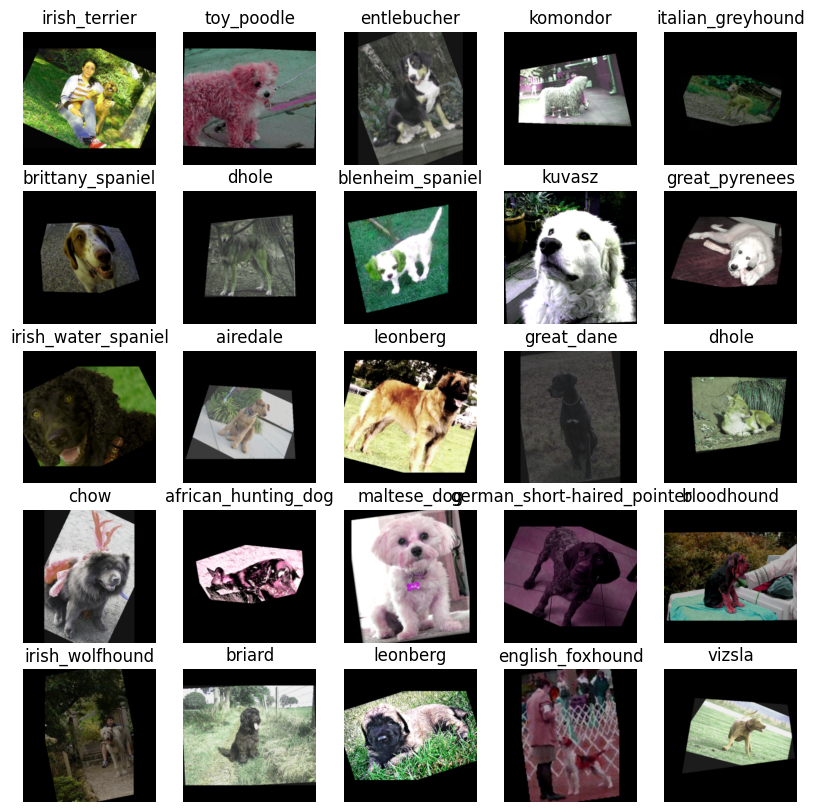

In [ ]:
_, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()
for ax in axs:
    img, label = train_dataset[random.randint(0, len(train_dataset))]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(num_to_class_mapping[int(label)])
    ax.axis('off')
plt.show()


### Define a Network
After preparing the data we define a network architecture.
There are a lot of possible architectures. A good start might be a slightly smaller
version of the famous VGG16 architecture. It consists of 4 blocks of 2 convolutional
layers followed by one max pooling step, then two fully connected layers of size 512
are used, for a total of around 5 million weight parameters.

Global average pooling is used instead of flattening to reduce the number of parameters
of the network. It takes the average of every input channel, so that a tensor of shape
14x14x512 results in a vector of 512 elements, each of which is the average of the
corresponding 14x14 slice.

Also let's define our device. The exercise will run without a GPU but it is probably
not feasible as computation on CPU would be magnitudes slower.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = nn.Sequential(
   # Block 1
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    # Block 2
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    # Block 3
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    # Block 4
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    # Flatten by global averaging.
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),

    # Output for 120 classes.
    nn.Linear(in_features=512, out_features=120),
).to(device)

In [ ]:
summary(model, input_size=(3, 224, 224), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4050 Laptop GPU'

In [ ]:
device#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NVIDIA GeForce RTX 4050 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.2 GB


In [ ]:
torch.cuda.current_device()

0

### Train the network

As usual, let's define an optimizer, loss function, dataloaders and training loop.

In [ ]:

epochs = 5
batch_size = 16
num_workers = 14

loss = (
    nn.CrossEntropyLoss()
)

optimizer = (
    Adam(model.parameters())
)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
)

def train(
        model: nn.Module,
        loss: nn.Module,
        optimizer: Optimizer,
        train_loader: DataLoader,
        val_loader: DataLoader,
        epochs: int
) -> dict:
    # Intermediate results during training will be saved here.
    # This allows plotting the training progress afterwards.
    metrics: dict = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    num_train_batches = ceil(len(train_loader.dataset) / batch_size)
    num_val_batches = ceil(len(val_loader.dataset) / batch_size)

    for ep in range(1, epochs + 1):
        total_loss = 0
        num_correct = 0

        for batch_idx, (x, y) in enumerate(train_loader):
            print(f'ep: {ep} and batch: {batch_idx}')
            x = x.to(device)
            y = y.to(device)

# TODO: Add forward pass + batch loss, backpropagation and apply gradients
            y_hat = model(x)
            batch_loss = loss(y_hat, y)
            
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            if batch_idx >= 0:
                print('TRAINING BATCH:\t({:5} / {:5})\tLOSS:\t{:.3f}'
                      .format(batch_idx, num_train_batches, float(batch_loss)), end='\r')

            total_loss += float(batch_loss)
            num_correct += int(torch.sum(torch.argmax(y_hat, dim=1) == y))

            # Print device information
            print(f"Epoch {batch_idx + 1}/{num_train_batches}")
            print(f"Model is on device: {next(model.parameters()).device}")
            #print(f"Data is on device: {x.device}")
            #print(f"Labels are on device: {y.device}")

            # Check CUDA memory usage
            print(f"CUDA memory allocated: {torch.cuda.memory_allocated(device)} bytes")
            print(f"CUDA memory reserved: {torch.cuda.memory_reserved(device)} bytes")


        ep_train_loss = total_loss / num_train_batches
        ep_train_acc = num_correct / len(train_loader.dataset)

        # Reset counters
        total_loss = 0
        num_correct = 0

        for batch_idx, (x, y) in enumerate(val_loader):
            x = x.to(device)
            y = y.to(device)

            with torch.no_grad():
# TODO: Do a forward pass and get the batch loss
                y_hat = model(x)
                batch_loss = loss(y_hat, y)

            if batch_idx % 10 == 0:
                print('VALIDATION BATCH:\t({:5} / {:5})\tLOSS:\t{:.3f}'
                      .format(batch_idx, num_val_batches, float(batch_loss)), end='\r')

            total_loss += float(batch_loss)
            num_correct += int(torch.sum(torch.argmax(y_hat, dim=1) == y))

        ep_val_loss = total_loss / num_val_batches
        ep_val_acc = num_correct / len(val_loader.dataset)

        metrics['train_loss'].append(ep_train_loss)
        metrics['train_acc'].append(ep_train_acc)
        metrics['val_loss'].append(ep_val_loss)
        metrics['val_acc'].append(ep_val_acc)

        print('EPOCH:\t{:5}\tTRAIN LOSS:\t{:.3f}\tTRAIN ACCURACY:\t{:.3f}\tVAL LOSS:\t'
              '{:.3f}\tVAL ACCURACY:\t{:.3f}'
              .format(ep, ep_train_loss, ep_train_acc,ep_val_loss, ep_val_acc,
                      end='\r'))
    return metrics

metrics = train(model, loss, optimizer, train_loader, val_loader, epochs)

We recycle the plotting function of lab 6 to plot the training progress:

In [14]:

def get_training_progress_plot(
        train_losses: list[float],
        train_accs: list[float],
        val_losses: list[float],
        val_accs: list[float],
) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2))

    ax1.set_title('Loss')
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.legend()

    ax2.set_title('Accuracy')
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Val Accuracy')
    ax2.legend()

get_training_progress_plot(
    metrics['train_loss'],
    metrics['train_acc'],
    metrics['val_loss'],
    metrics['val_acc'],
)

## Using a pretrained network
Even with the aid of data augmentation, the network does not perform good. This can be
explained by the fact that the images are quite diverse in relation to the size of the
training set. Data augmentation can only bring you so far, and even with the aid of
regularization the task would be difficult.

One popular trick to overcome this difficulty, known as _pre-training_, is to use another
CNN that has been trained on a different, larger dataset, for a related task. Most of the
weights of this network are then frozen (i.e., will not be updated),
and the last few layers (the "head") are replaced with new, freshly re-initialized ones
and learned from scratch.
What is the rationale behind freezing and unfreezing the weights?

PyTorch offers a variety of [pretrained models to download](https://pytorch.org/vision/stable/models.html).

After obtaining VGG16, our plan is to:

    1. Get the body of the downloaded net (accessible over `features` attribute)
    2. Create an extra head.
    3. Train only the weights of the head.

In [15]:

vgg_body = vgg16(pretrained=True, progress=False).features.to(device)
vgg_head = nn.Sequential(
# TODO: Add avg. pooling, two linear layers with 512 neurons and ReLU
# activation and a 120 neuron output layer.
).to(device)

head_optimizer = (
# Define an optimizer for the parameters of the head.
)

The documentation of VGG16 reveals that input images should be normalized with a given
range. Thus, we need to adjust the transforms of our datasets:

In [16]:
normalize_transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# Note: The clean way would be creating new datasets instead of modifiying internal structures.
train_dataset.transform.transforms.append(normalize_transform)
val_dataset.transform.transforms.append(normalize_transform)

In the next step, we modify our train function to implement the desired behaviour.
We train only the head for 10 epochs and then allow optimization of everything.


In [17]:
epochs = 15

def train(
        head: nn.Module,
        body: nn.Module,
        loss: nn.Module,
        head_optimizer: Optimizer,
        train_loader: DataLoader,
        val_loader: DataLoader,
        epochs: int
) -> dict:
    # Intermediate results during training will be saved here.
    # This allows plotting the training progress afterwards.
    metrics: dict = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    num_train_batches = ceil(len(train_loader.dataset) / batch_size)
    num_val_batches = ceil(len(val_loader.dataset) / batch_size)

    for ep in range(1, epochs + 1):
        total_loss = 0
        num_correct = 0

        for batch_idx, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)

# TODO: Do a forward pass through head/body and get the batch loss
# Hint: Using `no_grad()` on the pass through the body saves a lot of unnecessary computations.
            
            head_optimizer.zero_grad()
            batch_loss.backward()
            head_optimizer.step()

            if batch_idx % 10 == 0:
                print('TRAINING BATCH:\t({:5} / {:5})\tLOSS:\t{:.3f}'
                      .format(batch_idx, num_train_batches, float(batch_loss)), end='\r')

            total_loss += float(batch_loss)
            num_correct += int(torch.sum(torch.argmax(y_hat, dim=1) == y))


        ep_train_loss = total_loss / num_train_batches
        ep_train_acc = num_correct / len(train_loader.dataset)

        # Reset counters
        total_loss = 0
        num_correct = 0

        for batch_idx, (x, y) in enumerate(val_loader):
            x = x.to(device)
            y = y.to(device)

            with torch.no_grad():
# TODO: Do a forward pass through head/body and get the batch loss

            if batch_idx % 10 == 0:
                print('VALIDATION BATCH:\t({:5} / {:5})\tLOSS:\t{:.3f}'
                      .format(batch_idx, num_val_batches, float(batch_loss)), end='\r')

            total_loss += float(batch_loss)
            num_correct += int(torch.sum(torch.argmax(y_hat, dim=1) == y))

        ep_val_loss = total_loss / num_val_batches
        ep_val_acc = num_correct / len(val_loader.dataset)

        metrics['train_loss'].append(ep_train_loss)
        metrics['train_acc'].append(ep_train_acc)
        metrics['val_loss'].append(ep_val_loss)
        metrics['val_acc'].append(ep_val_acc)

        print('EPOCH:\t{:5}\tTRAIN LOSS:\t{:.3f}\tTRAIN ACCURACY:\t{:.3f}\tVAL LOSS:\t'
              '{:.3f}\tVAL ACCURACY:\t{:.3f}'
              .format(ep, ep_train_loss, ep_train_acc,ep_val_loss, ep_val_acc,
                      end='\r'))
    return metrics

metrics = train(
    head=vgg_head,
    body=vgg_body,
    head_optimizer=head_optimizer,
    loss=loss,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs
)

In [18]:
get_training_progress_plot(
    metrics['train_loss'],
    metrics['train_acc'],
    metrics['val_loss'],
    metrics['val_acc'],
)

As you can see, the results are much better now, and would keep improving if we had
trained for longer.


## Exercise 2
This exercise is about the receptive field of convolutional neural networks.
For our purposes, the receptive field of a neuron in layer $L$ contains the features
in a preceding layer $\ell$ that affect the output of said neuron, with $\ell=0$ being
the input to the network. In other words, changing any value in a neuron's receptive
field will change the output of that neuron. By going backwards from layer $L$,
convolutions and pooling operations enlarge the receptive field of neurons at layer
$L$, so that the deeper the network, the larger the receptive field of neurons at the
end ofthe network.

Let $\textbf{z}_\ell\in\mathbb{R}^{n_\ell}$ be the output of layer $\ell$
(and $\textbf{z}_0$ the input), that is obtained with a one-dimensional convolution or
pooling operation from $\textbf{z}_{\ell-1}$ with a kernel of size $k_\ell$ and stride
$s_\ell$. Define $r_\ell$ to be the size of the receptive field in the $\ell$-th layer
of a neuron in layer $L$, i.e. the minimum width of the largest region that contains
the elements in $\textbf{z}_\ell$ that affect a generic element in $\textbf{z}_L$.
Note that this region can contain gaps, i.e. neurons that do not affect the output of
the neuron in layer $L$, if they are in between neurons that do affect it.

**(a)** Show that $r_{\ell-1}$ can be computed from $r_\ell$ as follows:

\begin{equation}
r_{\ell-1}=s_\ell\cdot r_\ell+k_\ell-s_\ell
\end{equation}
You can consider padding to be infinite, or, equivalently, focus on the neurons in the
middle of the layer, without analyzing what happens near the borders.
Hint: consider the case $k_\ell=1$ first.

Then solve the recurrence to show that:

\begin{equation}
r_0=\sum_{\ell=1}^L\left(
\left(k_\ell-1\right)\prod_{i=1}^{\ell-1}s_i
\right)+1
\end{equation}

with the base case being $r_L=1$.

**(b)** Compute the receptive field size of the pre-trained VGG16 architecture we used above,
right before the global average pooling layer.

**(c)** Now suppose to have a dilation of $d_\ell\geq 1$ at every layer. What is the new formula
for $r_0$?

**(d)** What is the most effective way to increase the size of the receptive field of a neural
network?
